In [51]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Database

In [52]:
df = pd.DataFrame()
for tmp in os.listdir("bases/car-db/"):
    tmpDF = pd.read_csv(f"bases/car-db/{tmp}")
    tmpDF['car'] = tmp.split(".")[0]
    df = df.append(tmpDF)
    print(f"{tmp} - Nulls: {df.isna().sum().sum()}")
df.sample(5)

audi.csv - Nulls: 0
ford.csv - Nulls: 0
merc.csv - Nulls: 0
skoda.csv - Nulls: 0
toyota.csv - Nulls: 0
vauxhall.csv - Nulls: 0
vw.csv - Nulls: 0


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,car
3515,Fiesta,2016,9851,Manual,28581,Diesel,0,78.5,1.5,ford
3253,M Class,2013,15250,Automatic,56164,Diesel,200,44.8,2.1,merc
7997,Polo,2019,18745,Semi-Auto,4687,Petrol,145,39.8,2.0,vw
8172,Polo,2017,9990,Manual,20978,Petrol,145,60.1,1.2,vw
3446,Golf,2016,11450,Semi-Auto,43050,Diesel,30,62.8,2.0,vw


In [53]:
target_name = 'price'

# Categories

In [54]:
categories_cols = df.columns[df.dtypes == object]
df[categories_cols].nunique().sort_values()

transmission      4
fuelType          5
car               7
model           155
dtype: int64

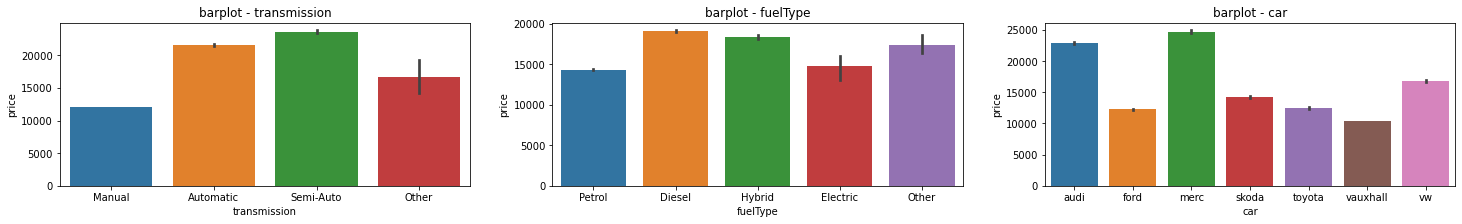

In [56]:
# Model high Cardinality
df.drop('model',axis=1,inplace=True,errors='ignore')

categories_cols = df.columns[df.dtypes == object]
f,axs = plt.subplots(1,3,figsize=(25,3))
for index,col in enumerate(categories_cols):
    axs[index].set_title(f"barplot - {col}")
    sns.barplot(y='price',x=col,data=df,ax=axs[index])
plt.show()

# Numeric

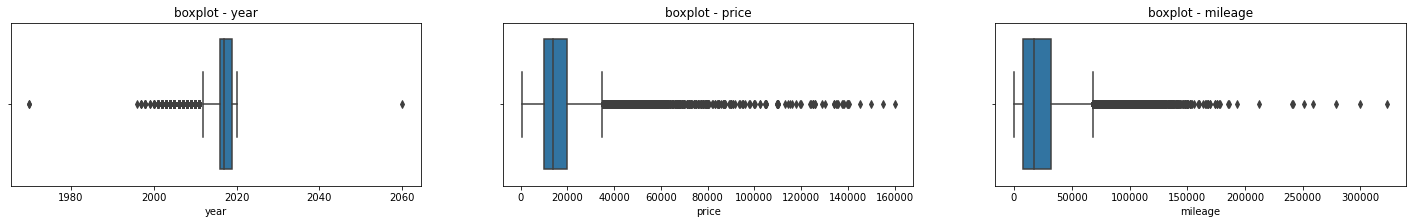

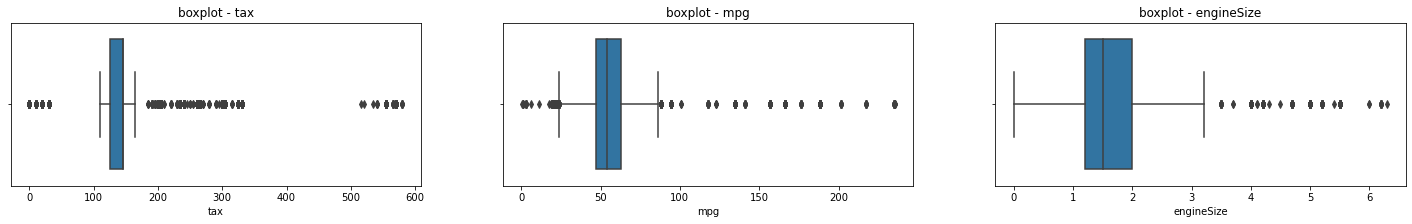

In [57]:
numeric_cols = df.columns[(df.dtypes != object)]


f,axs = plt.subplots(1,3,figsize=(25,3))
for index,col in enumerate(numeric_cols[:3]):
    axs[index].set_title(f"boxplot - {col}")
    sns.boxplot(df[col],ax=axs[index])
plt.show()

f,axs = plt.subplots(1,3,figsize=(25,3))
for index,col in enumerate(numeric_cols[3:]):
    axs[index].set_title(f"boxplot - {col}")
    sns.boxplot(df[col],ax=axs[index])
plt.show()

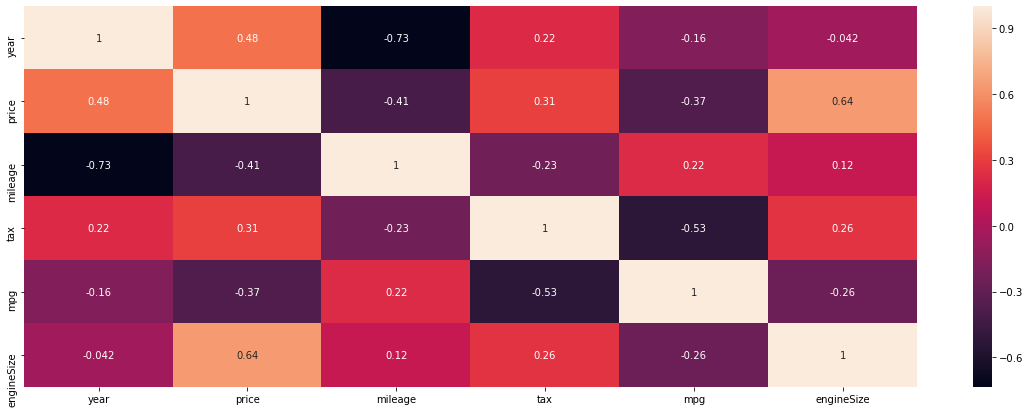

In [58]:
plt.figure(figsize=(20,7))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [59]:
df.quantile([0,0.01,0.05,0.5,0.95,0.99,1]).T

,0.00,0.01,0.05,0.50,0.95,0.99,1.00
year,1970.0,2010.0,2014.0,2017.0,2019.0,2020.0,2060.0
price,450.0,3990.0,6490.0,13990.0,32995.0,49990.0,159999.0
mileage,1.0,10.0,1000.0,17384.0,63100.0,96000.0,323000.0
tax,0.0,0.0,0.0,145.0,200.0,260.0,580.0
mpg,0.3,30.1,36.7,54.3,74.3,83.1,235.4
engineSize,0.0,1.0,1.0,1.5,2.4,3.0,6.3


In [60]:
import pandas_profiling

report = pandas_profiling.ProfileReport(df, title='Profile Report', html={'style':{'full_width':True}})

In [61]:
report.to_file("carAnalysis.html")

In [62]:
# Year Outlier
df = df[(df.year < 2022) & (df.year > 2009)]
df = df[df.engineSize > 0]

# Modelling

In [63]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

In [64]:
df = pd.get_dummies(df,drop_first=True)

In [65]:
df.reset_index(drop=True,inplace=True)
X = df.drop('price',axis=1)
y = df['price']

In [66]:
scaler = StandardScaler()
# same scale
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)

MMscaler = MinMaxScaler()
for col in X.columns[X.nunique() == 2]:
    X[col] = MMscaler.fit_transform(X[[col]]).astype(int)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [84]:
from sklearn.linear_model import LinearRegression, ElasticNet,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.svm import LinearSVR

In [69]:
from sklearn.model_selection import cross_validate, KFold, GridSearchCV

# Models

In [85]:
models = [
        {
            'model_name':'GradientBoostingRegressor',
            'params':{
                'n_estimators':[10,30],
                'max_depth':[1,4,10,None],
            },
            'model':GradientBoostingRegressor(random_state=42),
        },
        {
            'model_name':'LinearSVR',
            'params':{
                'C':[0.1,1,10],
            },
            'model':LinearSVR(random_state=42),
        },
        {
            'model_name':'RandomForestRegressor',
            'params':{
                'n_estimators':[10,30],
                'max_depth':[1,4,10,None],
            },
            'model':RandomForestRegressor(random_state=42),
        },
    {
        'model_name':'ElasticNet',
        'params':{
            'alpha':[0,0.1,0.5,0.9,1],
            'l1_ratio':[0,0.1,0.5,0.9,1],
        },
        'model':ElasticNet(),
    },
    {
        'model_name':'DecisionTreeRegressor',
        'params':{
            'max_depth':[3,10,40,None],
            'min_samples_split':[2,50,300]
        },
        'model':DecisionTreeRegressor(),
    },
    {
        'model_name':'KNeighborsRegressor',
        'params':{
            "n_neighbors":[3,5,7,9]
        },
        'model':KNeighborsRegressor(),
    }
]

# Cross Validation

In [86]:
evaluation = []
cv = KFold(3,shuffle=True,random_state=42)
for model in models:
    print("-----------")
    print(model['model_name'])
    
    grid = GridSearchCV(model['model'],param_grid=model['params'],cv=cv,return_train_score=True)
    grid.fit(X_train,y_train)
    print("\t", grid.best_score_)
    model['crossValidation'] = grid
    evaluation.append(model)

-----------
GradientBoostingRegressor
	 0.9302727498313266
-----------
LinearSVR
	 0.7646802133718819
-----------
RandomForestRegressor
	 0.9333454098587779
-----------
ElasticNet
	 0.7876084386999921
-----------
DecisionTreeRegressor
	 0.9099238650180445
-----------
KNeighborsRegressor
	 0.909141854062035


In [87]:
for model in models:
    results = pd.DataFrame(model['crossValidation'].cv_results_).query("rank_test_score == 1").iloc[0]
    model['mean_test_score'],model['std_test_score'] = results['mean_test_score'],results['std_test_score']
    model['mean_train_score'],model['std_train_score'] = results['mean_train_score'],results['std_train_score']

In [109]:
results = pd.DataFrame(models)
results = results[['model_name','mean_train_score','mean_test_score','std_train_score','std_test_score']].round(3)
results

,model_name,mean_train_score,mean_test_score,std_train_score,std_test_score
0,GradientBoostingRegressor,0.960,0.930,0.001,0.002
1,LinearSVR,0.765,0.765,0.001,0.001
2,RandomForestRegressor,0.989,0.933,0.000,0.002
3,ElasticNet,0.788,0.788,0.001,0.002
4,DecisionTreeRegressor,0.934,0.910,0.004,0.005
5,KNeighborsRegressor,0.935,0.909,0.001,0.003


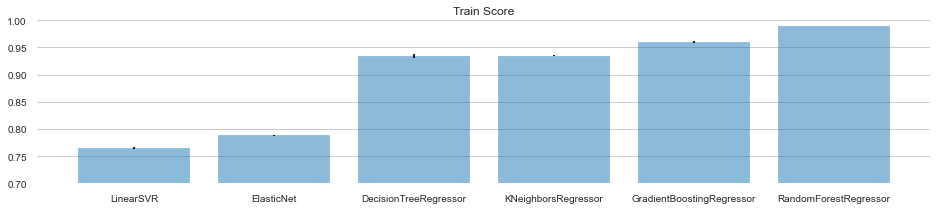

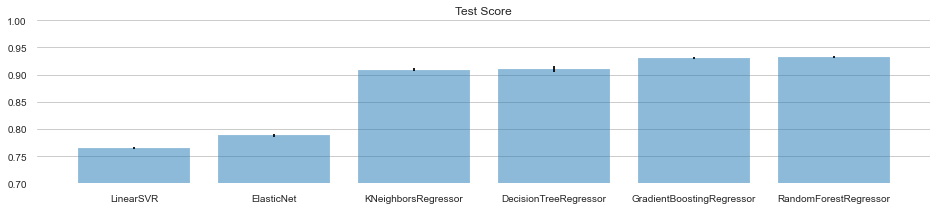

In [110]:
results.sort_values('mean_train_score',inplace=True)
plt.figure(figsize=(16,3))
plt.title("Train Score")
ax = plt.bar(x=results['model_name'],height=results['mean_train_score'],yerr=results['std_train_score'],align='center', alpha=0.5, ecolor='black', capsize=10)
plt.grid(axis='y')
plt.ylim(0.7,1)
plt.show()
results.sort_values('mean_test_score',inplace=True)
plt.figure(figsize=(16,3))
plt.title("Test Score")
ax = plt.bar(x=results['model_name'],height=results['mean_test_score'],yerr=results['std_test_score'],align='center', alpha=0.5, ecolor='black', capsize=10)
plt.grid(axis='y')
plt.ylim(0.7,1)
plt.show()